Clone into the repository to gain acces to the uci datasets

In [231]:
!git clone https://github.com/DavidSommer94/dagstuhl

fatal: destination path 'dagstuhl' already exists and is not an empty directory.


First, we have to install gpytorch which is pytorch's module containing Gaussian processes.



In [2]:
import torch
torch.set_default_dtype(torch.double)

In [3]:
!pip install gpytorch

In [4]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import MeanFieldVariationalDistribution
from gpytorch.variational import VariationalStrategy

import math

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = MeanFieldVariationalDistribution(num_inducing_points=inducing_points.shape[0])
        variational_strategy = VariationalStrategy(
            model=self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_func = gpytorch.means.ConstantMean()
        self.covariance_func = gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    a=1e-1,
                    b=10.
                ),
                # ard_num_dims=2
            )

    def forward(self, data):
        mean = self.mean_func(data)
        covariance = self.covariance_func(data)

        return gpytorch.distributions.MultivariateNormal(mean=mean, covariance_matrix=covariance)


Next we load the real data examples from the uci set.

In [5]:
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from scipy.io import loadmat
from math import floor

In [43]:
# 45730 Data points of 9 attributes/dimensions each  
data_set = loadmat('/content/dagstuhl/uci/protein.mat')['data']
data = data_set[:, :-1]        
data = (data - data.min(0)[0]) / (data.max(0)[0] - data.min(0)[0]) # normalize data on [0,1]
target = data_set[:, -1]


# # 48827 Data points of 20 attributes/dimensions each 
# data_set = loadmat('/content/dagstuhl/uci/keggdirected.mat')['data']
# data = data_set[:, :-1]
# data = (data - data.min(0)[0]) / (data.max(0)[0] - data.min(0)[0])
# target = data_set[:, -1]

# 40000 Data points of 8 attributes/dimensions each 
data_set = loadmat('/content/dagstuhl/uci/kin40k.mat')['data']
data = data_set[:, :-1]
data = (data - data.min(0)[0]) / (data.max(0)[0] - data.min(0)[0])
target = data_set[:, -1]

def create_toy_data(func, n=1000, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

data, target = create_toy_data(sinusoidal, n=100, std=.1, domain=[0., 1.])
data = data[:,None]
data_set = (data, target)
print(data.shape)
print(target.shape)

(100, 1)
(100,)


Define the training of the model.

In [44]:
num_train = int(floor(0.7 * len(data)))
num_val = int(floor(0.15 * len(data)))

dtype=torch.double
train_data = torch.as_tensor(data[: num_train, :], dtype=dtype)
train_target = torch.as_tensor(target[:num_train], dtype=dtype)
# train_loader = DataLoader(dataset=TensorDataset(train_data, train_target), batch_size=train_data.shape[0])

test_data = torch.as_tensor(data[num_train:num_train + num_val, :], dtype=dtype)
test_target = torch.as_tensor(target[num_train:num_train + num_val], dtype=dtype)

train_dataloader = DataLoader(dataset=TensorDataset(train_data, train_target), batch_size=1000)
test_dataloader = DataLoader(dataset=TensorDataset(test_data, test_target), batch_size=1000)

In [45]:
def train_loop(model, dataloader, loss_fn, optimizer):
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(model, dataloader, loss_fn):
    total_samples = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct/total_samples, test_loss / total_samples

In [46]:
import torch.nn as nn
from torch.optim import Adam

device = torch.device('cpu')
config = dict(
        gp_lr=1e-3,
        num_ind_points=100
    )

inducing_points = torch.rand((config['num_ind_points'], train_dataloader.dataset[0][0].shape[0]))

model = GPModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

optimizer = Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
    ],
    lr=config['gp_lr'],
    weight_decay=0.
)

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_dataloader.dataset)).to(device)
objective = nn.MSELoss(reduction='mean').to(device)

loss_fn = nn.CrossEntropyLoss()

def train_loop(model, dataloader, loss_fn, optimizer, verbose=False):
    for X, y in dataloader:
        pred = model(X)
        loss = -elbo(pred, y)
        
        optimizer.zero_grad()
        loss.backward()

        if verbose:
          print('Loss: %.3f   lengthscale: %.3f' % (
          loss.item(),
          model.covariance_func.lengthscale
          ))
        optimizer.step()

def test_loop(model, dataloader, loss_fn):
    total_samples = len(dataloader.dataset)
    test_loss = 0.
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += objective(pred.mean, y).item()
    return test_loss / total_samples

In [47]:
from tqdm import trange

epochs = 200
with trange(epochs) as pbar:
    for t in pbar:
        train_loop(model, train_dataloader, loss_fn, optimizer)
        avg_loss = test_loop(model, test_dataloader, loss_fn)
        pbar.set_description(f"Epoch {t+1}")
        pbar.set_postfix(loss=avg_loss)

avg_loss = test_loop(model, test_dataloader, loss_fn)
print(f"Done! Loss: {avg_loss:f}")


Epoch 200: 100%|██████████| 200/200 [00:04<00:00, 42.72it/s, loss=0.0376]

Done! Loss: 0.037637


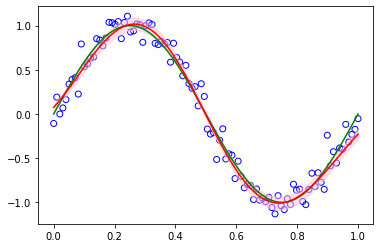

In [ ]:
if (data.shape[1] == 1 and len(target.shape) == 1):

  x = torch.linspace(0,1,100)[:,None]
  mean = model(x).mean.detach().numpy()
  cr1, cr2 = model(x).confidence_region()
  cr1 = cr1.detach().numpy()
  cr2 = cr2.detach().numpy()
  from matplotlib import pyplot as plt


  plt.scatter(data, target, facecolor="none", edgecolor="b", color="blue", label="training")
  plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
  plt.plot(x, mean, color="r", label="gpr")
  plt.fill_between(torch.squeeze(x), cr1, cr2, alpha=0.5, color="pink", label="std")
  plt.show()